# MS035 Preprocess
Created: 01/29/2024 \
Updated: 09/16/2024

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
from ast import literal_eval



import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/LFPAnalysis/')

In [4]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [5]:
# Specify root directory for un-archived data and results 
base_dir = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'

subj_id = 'MS035'
subj_format = ['edf']
subj_site = ['MSSM']


In [6]:
#### print date of last run
date = datetime.date.today().strftime('%m%d%Y')
print(date)

09162024


# Make mne_data


### Load and resample data


In [7]:
edf_files = glob(f'{neural_dir}{subj_id}/raw/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)


Extracting EDF parameters from /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS035/raw/MS035_SWB.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3394047  =      0.000 ...  3314.499 secs...


In [8]:
mne_data

<RawEDF | MS035_SWB.edf, 276 x 3394048 (3314.5 s), ~6.98 GB, data loaded>

In [8]:
# mne_data.ch_names

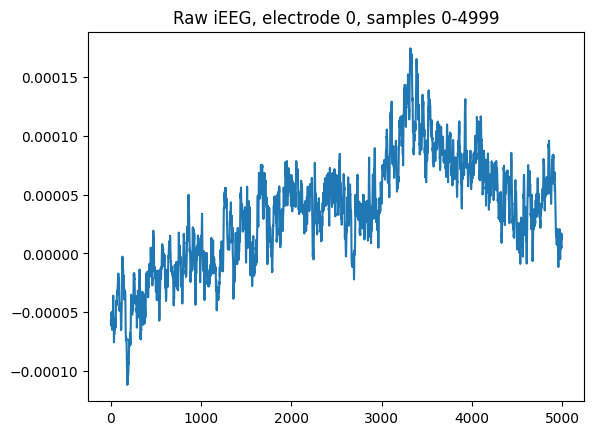

In [9]:
# Sanity check one channel data

plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Resampling data 

In [10]:
#resampling if patient is not sampled at 512
resample_sr = 500
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 276 out of 276 | elapsed:  2.0min finished


<RawEDF | MS035_SWB.edf, 276 x 1657250 (3314.5 s), ~3.41 GB, data loaded>

### Notch filter line noise

In [11]:
mne_data.info['line_freq'] = 60
# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 276 out of 276 | elapsed:   14.1s finished


<RawEDF | MS035_SWB.edf, 276 x 1657250 (3314.5 s), ~3.41 GB, data loaded>

### Photodiode
- examine photodiode 

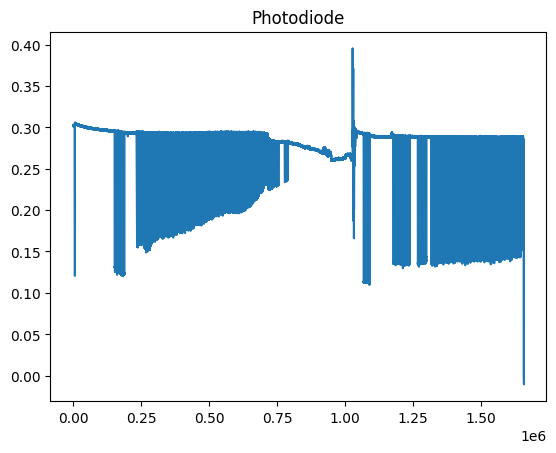

In [12]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("DC1")
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

In [13]:
mne_data.save(f'{neural_dir}{subj_id}/photodiode.fif', picks='DC1', overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS035/photodiode.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS035/photodiode.fif
[done]


In [14]:
mne_data.drop_channels(['DC1'])

<RawEDF | MS035_SWB.edf, 275 x 1657250 (3314.5 s), ~3.40 GB, data loaded>

### Anatomical Localization

In [15]:
### Rename channels to be lowercase before anatomical localization
new_name_dict = {x:x.replace(" ", "").lower() for x in mne_data.ch_names}
mne_data.rename_channels(new_name_dict)

<RawEDF | MS035_SWB.edf, 275 x 1657250 (3314.5 s), ~3.40 GB, data loaded>

In [16]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,ManualExamination,Notes
0,LaCaS1,A32sg_L,-4.193839,40.722342,-1.249460,-3.409516,28.122622,-4.643328,Gray,Left ACgG anterior cingulate gyrus,Area s24,L ACC,L CG,Left cingulate gyrus C,NaN,NaN
1,LaCaS10,A9/46d_L,-21.368608,57.508612,37.129623,-23.595365,46.014935,36.574161,Gray,Left SFG superior frontal gyrus,Unknown,L Middle Frontal Gyrus,L MFG,Left middle frontal gyrus 3 A,NaN,NaN
2,LaCaS11,A9/46d_L,-23.365674,59.506978,41.127445,-25.838634,48.159044,40.898034,Unknown,Left SFG superior frontal gyrus,Unknown,L Superior Frontal Gyrus,L MFG,Left middle frontal gyrus 3 A,oob,NaN
3,LaCaS12,Unknown,-25.362740,60.705997,45.525048,-28.069497,49.502020,45.723240,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,oob,NaN
4,LaCaS2,A32sg_L,-6.190905,42.321034,2.748361,-5.845285,29.986278,-0.298868,White,Left Cerebral White Matter,Unknown,L Olfactory cortex,L CG,Unknown,WM,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,RmOlF5,A11l_R,19.371542,47.117112,-6.846410,23.356883,34.915942,-10.712708,White,Right MOrG medial orbital gyrus,Area Fo3,R IFG (p Orbitalis),R OrG,Right frontal orbital 4 D,WM,NaN
168,RmOlF6,A11l_R,23.765087,46.717439,-4.047935,28.298187,34.880922,-7.718436,Gray,Right POrG posterior orbital gyrus,Area Fo3,R IFG (p Orbitalis),R OrG,Right frontal orbital 4 D,NaN,NaN
169,RmOlF7,A12/47o_R,27.759220,46.717439,-1.249460,32.784291,35.177035,-4.651516,White,Right Cerebral White Matter,Unknown,R IFG (p Orbitalis),R OrG,Unknown,WM,NaN
170,RmOlF8,A44op_R,31.753352,46.717439,1.948797,37.260470,35.337213,-1.005693,Gray,Right Cerebral White Matter,Unknown,R IFG (p Orbitalis),R IFG,Right anterior pars triangularis B,NaN,NaN


In [17]:
list(elec_locs.label)

['LaCaS1',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LAglT1',
 'LAglT10',
 'LAglT2',
 'LAglT3',
 'LAglT4',
 'LAglT5',
 'LAglT6',
 'LAglT7',
 'LAglT8',
 'LAglT9',
 'LaImM1',
 'LaImM10',
 'LaImM11',
 'LaImM12',
 'LaImM13',
 'LaImM14',
 'LaImM15',
 'LaImM16',
 'LaImM2',
 'LaImM3',
 'LaImM4',
 'LaImM5',
 'LaImM6',
 'LaImM7',
 'LaImM8',
 'LaImM9',
 'LCMiP1',
 'LCMiP10',
 'LCMiP11',
 'LCMiP12',
 'LCMiP13',
 'LCMiP14',
 'LCMiP2',
 'LCMiP3',
 'LCMiP4',
 'LCMiP5',
 'LCMiP6',
 'LCMiP7',
 'LCMiP8',
 'LCMiP9',
 'LHplT1',
 'LHplT10',
 'LHplT11',
 'LHplT12',
 'LHplT2',
 'LHplT3',
 'LHplT4',
 'LHplT5',
 'LHplT6',
 'LHplT7',
 'LHplT8',
 'LHplT9',
 'LmCmS1',
 'LmCmS10',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmOlF1',
 'LmOlF10',
 'LmOlF11',
 'LmOlF12',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'RaCaS1',
 'RaCaS10',
 'RaCaS1

In [18]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['lmoif1', 'lmoif2', 'lmoif3', 'lmoif4', 'lmoif5', 'lmoif6', 'lmoif7', 'lmoif8', 'lmoif9', 'lmoif10', 'lmoif11', 'lmoif12', 'rmoifm1', 'rmoifm2', 'rmoifm3', 'rmoifm4', 'rmoifm5', 'rmoifm6', 'rmoifm7', 'rmoifm8', 'rmoifm9', 'rmoifm10', 'rmoifm11', 'rmoifm12', 'lalmm1', 'lalmm2', 'lalmm3', 'lalmm4', 'lalmm5', 'lalmm6', 'lalmm7', 'lalmm8', 'lalmm9', 'lalmm10', 'lalmm11', 'lalmm12', 'lalmm13', 'lalmm14', 'lalmm15', 'lalmm16', 'ralms1', 'ralms2', 'ralms3', 'ralms4', 'ralms5', 'ralms6', 'ralms7', 'ralms8', 'ralms9', 'ralms10', 'ralms11', 'ralms12', 'ralms13', 'ralms14', 'ralms15', 'ralms16', 'c57', 'c58', 'c59', 'c60', 'c61', 'c62', 'c63', 'c64', 'lagit1', 'lagit2', 'lagit3', 'lagit4', 'lagit5', 'lagit6', 'lagit7', 'lagit8', 'lagit9', 'lagit10', 'ragit1', 'ragit2', 'ragit3', 'ragit4', 'ragit5', 'ragit6', 'ragit7', 'ragit8', 'ragit9', 'ragit10', 'lhpit1', 'lhpit2', 'lhpit3', 'lhpit4', 'lhpit5', 'lhpit6', 'lhpit7', 'lhpit8', 'lhpit9', 'lhpit10', 'lhpit11', 'lhpit12', 'rhpit1', 'rhpit2', 'rhpit

In [19]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


Number of electrodes in the mne file is greater than the number of electrodes in the localization file


In [20]:
unmatched_seeg #make sure there are no unmatched names


[]

In [21]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [22]:
new_name_dict #make sure this passes the eye test 


{'lmoif1': 'lmolf1',
 'lmoif2': 'lmolf2',
 'lmoif3': 'lmolf3',
 'lmoif4': 'lmolf4',
 'lmoif5': 'lmolf5',
 'lmoif6': 'lmolf6',
 'lmoif7': 'lmolf7',
 'lmoif8': 'lmolf8',
 'lmoif9': 'lmolf9',
 'lmoif10': 'lmolf10',
 'lmoif11': 'lmolf11',
 'lmoif12': 'lmolf12',
 'rmoifm1': 'rmolf1',
 'rmoifm2': 'rmolf2',
 'rmoifm3': 'rmolf3',
 'rmoifm4': 'rmolf4',
 'rmoifm5': 'rmolf5',
 'rmoifm6': 'rmolf6',
 'rmoifm7': 'rmolf7',
 'rmoifm8': 'rmolf8',
 'rmoifm9': 'rmolf9',
 'rmoifm10': 'rmolf10',
 'rmoifm11': 'rmolf11',
 'rmoifm12': 'rmolf12',
 'lalmm1': 'laimm1',
 'lalmm2': 'laimm2',
 'lalmm3': 'laimm3',
 'lalmm4': 'laimm4',
 'lalmm5': 'laimm5',
 'lalmm6': 'laimm6',
 'lalmm7': 'laimm7',
 'lalmm8': 'laimm8',
 'lalmm9': 'laimm9',
 'lalmm10': 'laimm10',
 'lalmm11': 'laimm11',
 'lalmm12': 'laimm12',
 'lalmm13': 'laimm13',
 'lalmm14': 'laimm14',
 'lalmm15': 'laimm15',
 'lalmm16': 'laimm16',
 'ralms1': 'raims1',
 'ralms2': 'raims2',
 'ralms3': 'raims3',
 'ralms4': 'raims4',
 'ralms5': 'raims5',
 'ralms6': 'raims

In [23]:
# Rename the mne data according to the localization data

mne_data.rename_channels(new_name_dict)

<RawEDF | MS035_SWB.edf, 275 x 1657250 (3314.5 s), ~3.40 GB, data loaded>

In [24]:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of {len(left_seeg_names)} left sEEG and {len(right_seeg_names)} right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')



We have a total of 86 left sEEG and 86 right sEEG electrodes
We have a total of 172 sEEG electrodes


In [25]:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
mne_data.set_channel_types(sEEG_mapping_dict)


<RawEDF | MS035_SWB.edf, 275 x 1657250 (3314.5 s), ~3.40 GB, data loaded>

In [26]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names))
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs 

<RawEDF | MS035_SWB.edf, 172 x 1657250 (3314.5 s), ~2.12 GB, data loaded>

In [27]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | MS035_SWB.edf, 172 x 1657250 (3314.5 s), ~2.12 GB, data loaded>

In [28]:
#this is just for my own personal info and to select how many channels to visualize at a time
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)
# probe_names

In [29]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [30]:
probe_ch_counts

{'lacas': 12,
 'laglt': 10,
 'laimm': 16,
 'lcmip': 14,
 'lhplt': 12,
 'lmcms': 10,
 'lmolf': 12,
 'racas': 14,
 'raglt': 10,
 'raims': 16,
 'rcmip': 14,
 'rhplt': 10,
 'rmcms': 10,
 'rmolf': 12}

## ~DEPRECIATED - Signal Cleaning Before Re-Ref~

~- Use manual bad channel detection for **bipolar** referencing
    - bipolar referencing completely ignores channels labeled as 'bad' so do not remove unless absolutely necessary~ \
~- This process is iterative depending on how TFRs look.~

In [11]:
# mne_data.info['bads'] = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) #this is likely inaccurate - just use to get an idea 
# lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict)

In [12]:
#  %matplotlib notebook
# fig = mne_data.plot(start=0, duration=1000, n_channels=40, scalings=mne_data._data.max()/30)


In [13]:
# mne_data.info['bads'] = ['raglt9', 'laimm16']


## Save mne_data
NO CHANNEL REMOVAL BEFORE RE-REFERENCING \
**PIPELINE CHANGE IMPLEMENTED 05/09/2024**

In [31]:
mne_data.save(f'{neural_dir}{subj_id}/raw_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS035/raw_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS035/raw_ieeg.fif
[done]


# Re-referencing + Signal Cleaning
1. bipolar rereference raw ieeg data 
2. plot lfp + psd for bp data
3. remove bad bp reref channels
4. localize roi for reref channels
5. save bp reref data & localization info


In [32]:
#run if only re-ref
anat_file = glob(f'{anat_dir}/{subj_id}_labels.csv')[0]
mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif', preload=True)

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS035/raw_ieeg.fif...
    Range : 0 ... 1657249 =      0.000 ...  3314.498 secs
Ready.
Reading 0 ... 1657249  =      0.000 ...  3314.498 secs...


### Bipolar Re-ref

In [33]:
# Re-reference neural data
mne_data_bp_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                              elec_path=anat_file, 
                                              method='bipolar', 
                                              site='MSSM')

sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=106, n_times=1657250
    Range : 0 ... 1657249 =      0.000 ...  3314.498 secs
Ready.
Added the following bipolar channels:
lacas1-lacas2, lacas8-lacas9, lacas9-lacas10, laglt1-laglt2, laglt2-laglt3, laglt3-laglt4, laglt4-laglt5, laglt5-laglt6, laglt6-laglt7, laglt7-laglt8, laglt8-laglt9, laglt9-laglt10, laimm1-laimm2, laimm2-laimm3, laimm3-laimm4, laimm4-laimm5, laimm5-laimm6, laimm6-laimm7, laimm8-laimm9, laimm9-laimm10, laimm10-laimm11, laimm11-laimm12, laimm12-laimm13, laimm13-laimm14, lcmip1-lcmip2, lcmip2-lcmip3, lcmip3-lcmip4, lcmip4-lcmip5, lcmip7-lcmip8, lcmip8-lcmip9, lcmip9-lcmip10, lcmip10-lcmip11, lcmip11-lcmip12, lcmip12-lcmip13, lcmip13-lcmip14, lhplt1-lhplt2, lhplt3-lhplt4, lhplt4-lhplt5, lhplt5-lhplt6, lhplt6-lhplt7, lhplt7-lhplt8, lhplt8-lhplt9, lmcms1-lmcms2, lmcms2-lmcms3, lmcms3-lmcms4, lmcms4-lmcms5, lmcms5-lmcms6, lmcms6-lmcms7, lmcms7-lmcms8, lmcms8-lmcms9, lmolf1-lmolf

In [34]:
mne_data_bp_reref

<Raw | raw_ieeg.fif, 106 x 1657250 (3314.5 s), ~1.31 GB, data loaded>

In [35]:
mne_data_bp_reref.ch_names

['lacas1-lacas2',
 'lacas8-lacas9',
 'lacas9-lacas10',
 'laglt1-laglt2',
 'laglt2-laglt3',
 'laglt3-laglt4',
 'laglt4-laglt5',
 'laglt5-laglt6',
 'laglt6-laglt7',
 'laglt7-laglt8',
 'laglt8-laglt9',
 'laglt9-laglt10',
 'laimm1-laimm2',
 'laimm2-laimm3',
 'laimm3-laimm4',
 'laimm4-laimm5',
 'laimm5-laimm6',
 'laimm6-laimm7',
 'laimm8-laimm9',
 'laimm9-laimm10',
 'laimm10-laimm11',
 'laimm11-laimm12',
 'laimm12-laimm13',
 'laimm13-laimm14',
 'lcmip1-lcmip2',
 'lcmip2-lcmip3',
 'lcmip3-lcmip4',
 'lcmip4-lcmip5',
 'lcmip7-lcmip8',
 'lcmip8-lcmip9',
 'lcmip9-lcmip10',
 'lcmip10-lcmip11',
 'lcmip11-lcmip12',
 'lcmip12-lcmip13',
 'lcmip13-lcmip14',
 'lhplt1-lhplt2',
 'lhplt3-lhplt4',
 'lhplt4-lhplt5',
 'lhplt5-lhplt6',
 'lhplt6-lhplt7',
 'lhplt7-lhplt8',
 'lhplt8-lhplt9',
 'lmcms1-lmcms2',
 'lmcms2-lmcms3',
 'lmcms3-lmcms4',
 'lmcms4-lmcms5',
 'lmcms5-lmcms6',
 'lmcms6-lmcms7',
 'lmcms7-lmcms8',
 'lmcms8-lmcms9',
 'lmolf1-lmolf2',
 'lmolf4-lmolf5',
 'lmolf5-lmolf6',
 'lmolf6-lmolf7',
 'lmolf7

# Manual Signal Cleaning 
Methods:
- Use manual bad channel removal for **bipolar** re referenced data 
- This process is iterative depending on how TFRs look. 

<IPython.core.display.Javascript object>


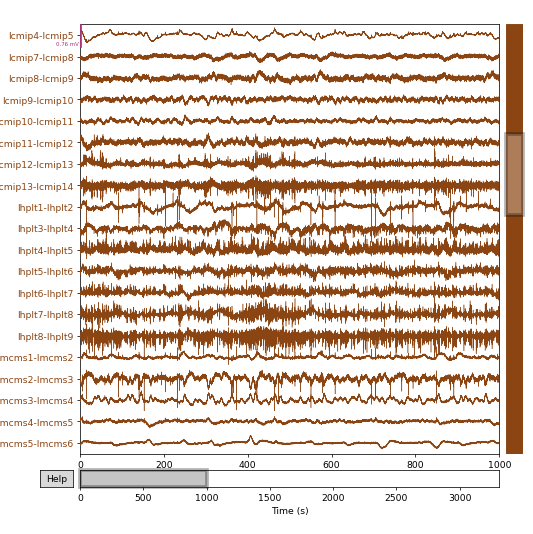

In [37]:
 %matplotlib notebook
fig = mne_data_bp_reref.plot(start=0, duration=1000, n_channels=20, scalings=mne_data_bp_reref._data.max()/5)


Effective window size : 0.512 (s)


<IPython.core.display.Javascript object>


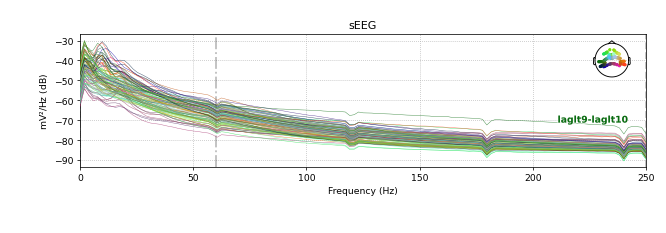

<IPython.core.display.Javascript object>


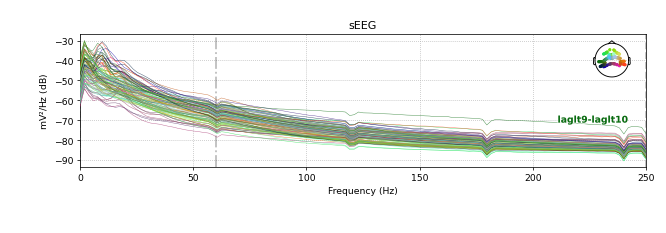

In [38]:
mne_data_bp_reref.compute_psd().plot()

In [39]:
print(mne_data_bp_reref.info['bads'],date)

[] 05212024


## Save Reref Data

In [40]:
mne_data_bp_reref.save(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS035/bp_ref_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS035/bp_ref_ieeg.fif
[done]


In [41]:
#remove mne_data from environment to save memory 
del mne_data, mne_data_bp_reref

# Photodiode Alignment
SWB photodiodes should be aligned to TrialOnset
- extract TrialOnset times to align to photodiode deflection onset 
- clean photodiode data if necessary (if photodiode is inverted, noisy etc)
- align photodiode (if function fails, try manual alignment)
- verify proper alignment by plotting

In [7]:
#load behavior data
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_task_data')
behav_df = behav_df[:-2]
beh_ts   = behav_df['TrialOnset'] #timestamp that should be aligned to photodiode 
behav_df

,Round,Trial Num,TrialType,TrialOnset,ChoiceOnset,DecisionOnset,FeedbackOnset,RT,SafeBet,LowBet,...,totalCPE,decisionCPE,totalRegret,decisionRegret,totalRelief,decisionRelief,totalCF,decisionCF,pRPE,nRPE
0,1,10.0,mix,505.929371,505.938654,508.831753,508.839507,2.893099,0.0,-0.50,...,-0.20,-0.20,-0.20,-0.20,0.00,0.00,0.20,0.20,0.000,0.00
1,2,131.0,loss,515.781024,515.790758,518.126958,520.141936,2.336200,-0.5,-0.84,...,-0.84,-0.34,-0.84,-0.34,0.00,0.00,0.00,-0.50,0.000,-0.42
2,3,70.0,gain,524.844795,524.850467,527.388776,529.405157,2.538309,0.3,0.00,...,-1.50,-0.30,-1.50,-0.30,0.00,0.00,1.50,0.30,0.000,-0.75
3,4,148.0,loss,541.114294,541.115059,545.162128,545.170220,4.047069,-0.6,-2.16,...,1.56,1.56,0.00,0.00,1.56,1.56,-2.16,-2.16,0.000,0.00
4,5,78.0,gain,552.213605,552.214416,556.623420,558.639138,4.409004,0.4,0.00,...,-1.44,-0.40,-1.44,-0.40,0.00,0.00,1.44,0.40,0.000,-0.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,57.0,gain,3190.401483,3190.408759,3193.064740,3195.080798,2.655981,0.2,0.00,...,0.63,0.43,0.00,0.00,0.63,0.43,0.00,0.20,0.315,0.00
146,147,41.0,mix,3200.048826,3200.057539,3203.176010,3205.192374,3.118471,0.0,-0.80,...,-1.76,-0.80,-1.76,-0.80,0.00,0.00,0.96,0.00,0.000,-0.88
147,148,136.0,loss,3217.800623,3217.808733,3220.583522,3220.590640,2.774789,-0.5,-1.40,...,0.90,0.90,0.00,0.00,0.90,0.90,-1.40,-1.40,0.000,0.00
148,149,128.0,loss,3227.452766,3227.453485,3231.193626,3231.198316,3.740141,-0.4,-1.44,...,1.04,1.04,0.00,0.00,1.04,1.04,-1.44,-1.44,0.000,0.00


In [8]:
#load photodiode data
photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS035/photodiode.fif...
Isotrak not found
    Range : 0 ... 1657249 =      0.000 ...  3314.498 secs
Ready.
Reading 0 ... 1657249  =      0.000 ...  3314.498 secs...


In [9]:
photodiode_data

<Raw | photodiode.fif, 1 x 1657250 (3314.5 s), ~12.7 MB, data loaded>

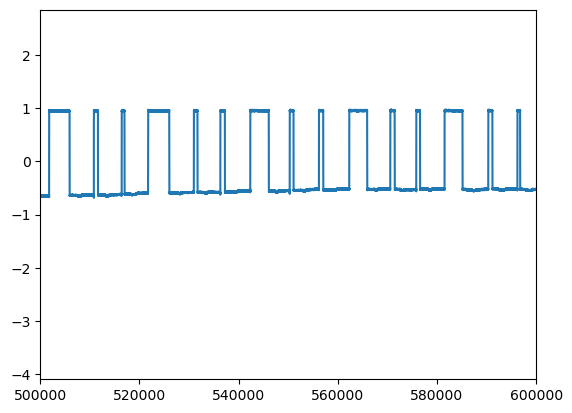

In [10]:
plt.plot(zscore(photodiode_data._data[0,:]))
plt.xlim([500000,600000])
plt.show()


In [11]:
temp_diode = photodiode_data.copy()
temp_diode._data = -temp_diode._data



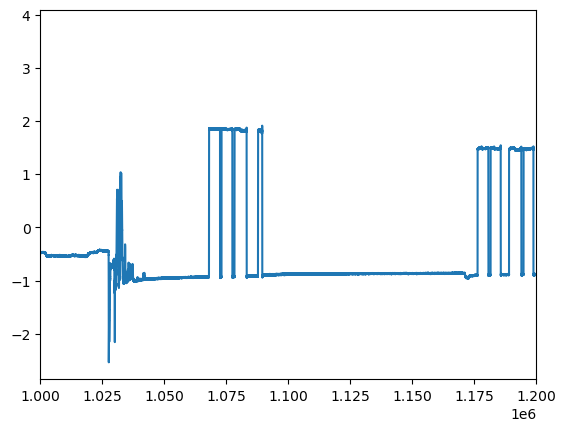

In [12]:
plt.plot(zscore(temp_diode._data[0,:]))
plt.xlim([1000000,1200000])
plt.show()


In [13]:
### Photodiode alignment
smoothSize=11
windSize=15
height=1.375


# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            temp_diode, #
                                            smoothSize, windSize, height)

19 blocks
...................

found matches for 45 of 293 pulses


In [14]:
print(slope, offset,smoothSize,windSize,height)

0.9999963140004382 14.308772687641067 11 15 1.375


In [15]:
# calculate pulse times from slope + offset
pulses = [(x*slope + offset) for x in beh_ts]
len(pulses) 

150

In [16]:
##### validate by plotting!
photo_sfreq = photodiode_data.info['sfreq']
photo_sfreq


500.0

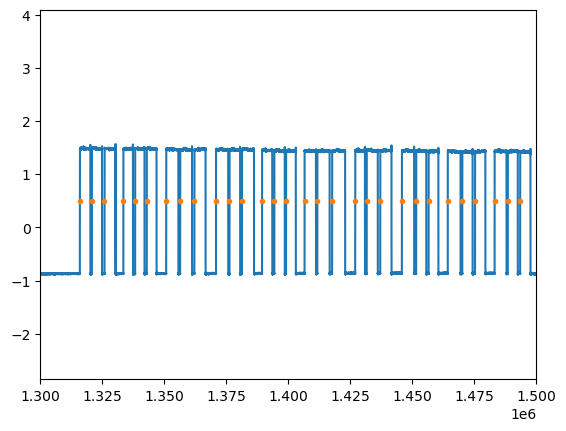

In [17]:
plt.plot(scipy.stats.zscore(-photodiode_data._data[0,:]))
plt.plot(np.array(pulses)*photo_sfreq, 
         np.ones_like(np.array(pulses)*photo_sfreq)-0.5, '.')


plt.xlim([1300000,1500000])
# plt.xlim([1500000,1600000])
# plt.xlim([300000,500000])
plt.show()

In [18]:
print(slope, offset,smoothSize,windSize,height)

0.9999963140004382 14.308772687641067 11 15 1.375


In [19]:
photodiode_params = np.array([slope, offset])
diode_info_fname  = f'{neural_dir}diode_info/{subj_id}_diode_info'
np.save(diode_info_fname, photodiode_params)


# Epoch Data
- Epoch neural data into trial epochs (and save df with IEDs/artifacts for every ev)
- Save epochs
- Baseline + decompose data into TFRs
- Add behavioral data to epochs metadata
- Plot + save TFRs (examine quality)

Note: Check whether data is ready to be analyzed - if this step shows noise then steps above should be repeated


In [7]:
diode_info_fname  = f'{neural_dir}diode_info/{subj_id}_diode_info.npy'
photodiode_params = np.load(diode_info_fname)

photodiode_params

array([ 0.99999631, 14.30877269])

In [8]:
slope, offset = photodiode_params


In [ ]:
#to reload for more cleaning if necessary
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)

### Get behavior ts for epochs of interest
- time points in SWB code are nonsensical - choice onset is a repeat of trial onset, and the difference between choice onset and decision onset is just the RT.
- even worse, feedback onset does not accurately mark feedback for safe choice trials - the feedback time is the safe outcome reveal, NOT counterfactual feedback. There is no true counterfactual feedback timestamp that's accurate for every trial. 
- Solution - make a new timestamp vector that is +2 seconds after DecisionOnset to use for counterfactual outcome feedback epochs


MAJOR UPDATE 05/09/2024 FROM PIPELINE UPDATE

In [9]:
#### load behavior data and define baseline/analysis epoch timepoints 

#load behavior data
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
behav_df = behav_df[:-2]
# behav_df = behav_df[behav_df['FeedbackOnset'] != 0] #remove fail trials from behav df
behav_df

,Round,Trial Num,TrialType,TrialOnset,ChoiceOnset,DecisionOnset,FeedbackOnset,RT,SafeBet,LowBet,...,totalCPE,decisionCPE,totalRegret,decisionRegret,totalRelief,decisionRelief,totalCF,decisionCF,pRPE,nRPE
0,1,10.0,mix,505.929371,505.938654,508.831753,508.839507,2.893099,0.0,-0.50,...,-0.20,-0.20,-0.20,-0.20,0.00,0.00,0.20,0.20,0.000,0.00
1,2,131.0,loss,515.781024,515.790758,518.126958,520.141936,2.336200,-0.5,-0.84,...,-0.84,-0.34,-0.84,-0.34,0.00,0.00,0.00,-0.50,0.000,-0.42
2,3,70.0,gain,524.844795,524.850467,527.388776,529.405157,2.538309,0.3,0.00,...,-1.50,-0.30,-1.50,-0.30,0.00,0.00,1.50,0.30,0.000,-0.75
3,4,148.0,loss,541.114294,541.115059,545.162128,545.170220,4.047069,-0.6,-2.16,...,1.56,1.56,0.00,0.00,1.56,1.56,-2.16,-2.16,0.000,0.00
4,5,78.0,gain,552.213605,552.214416,556.623420,558.639138,4.409004,0.4,0.00,...,-1.44,-0.40,-1.44,-0.40,0.00,0.00,1.44,0.40,0.000,-0.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,57.0,gain,3190.401483,3190.408759,3193.064740,3195.080798,2.655981,0.2,0.00,...,0.63,0.43,0.00,0.00,0.63,0.43,0.00,0.20,0.315,0.00
146,147,41.0,mix,3200.048826,3200.057539,3203.176010,3205.192374,3.118471,0.0,-0.80,...,-1.76,-0.80,-1.76,-0.80,0.00,0.00,0.96,0.00,0.000,-0.88
147,148,136.0,loss,3217.800623,3217.808733,3220.583522,3220.590640,2.774789,-0.5,-1.40,...,0.90,0.90,0.00,0.00,0.90,0.90,-1.40,-1.40,0.000,0.00
148,149,128.0,loss,3227.452766,3227.453485,3231.193626,3231.198316,3.740141,-0.4,-1.44,...,1.04,1.04,0.00,0.00,1.04,1.04,-1.44,-1.44,0.000,0.00


In [10]:
list(zip(behav_df.GambleChoice,behav_df.DecisionOnset,behav_df.FeedbackOnset))

[('safe', 508.8317526001483, 508.83950710017234),
 ('gamble', 518.1269582002424, 520.1419355003163),
 ('gamble', 527.3887758003548, 529.4051572000608),
 ('safe', 545.1621277001686, 545.170220200438),
 ('gamble', 556.6234199004248, 558.6391381002031),
 ('gamble', 566.5007249000482, 568.516431200318),
 ('safe', 583.2250989000313, 583.22980070021),
 ('gamble', 595.5361003000289, 597.5522896000184),
 ('gamble', 607.3131576003507, 609.328225100413),
 ('gamble', 625.0198795003816, 627.0364230000414),
 ('safe', 639.5463295001537, 639.5541052999906),
 ('gamble', 650.6062616002746, 652.6230398002081),
 ('safe', 670.5797050003894, 670.5880402000621),
 ('gamble', 681.8565494003706, 683.8721320000477),
 ('safe', 696.1328053004108, 696.1398853003047),
 ('gamble', 717.0214070002548, 719.0380446002819),
 ('gamble', 731.8974283002317, 733.913643900305),
 ('safe', 741.3756307000294, 741.3832086003385),
 ('gamble', 759.8484376003034, 761.8649334004149),
 ('gamble', 773.8585498002358, 775.8752492000349),

In [11]:
behav_df['CpeOnset'] = behav_df.DecisionOnset + 2.0
behav_df['CpeOnset']

0       510.831753
1       520.126958
2       529.388776
3       547.162128
4       558.623420
          ...     
145    3195.064740
146    3205.176010
147    3222.583522
148    3233.193626
149    3244.005103
Name: CpeOnset, Length: 150, dtype: float64

## SWB Epochs:

**Baseline epoch** = 1 sec prior to trial onset \
**Decision epoch** = 0.5 sec prior to decision onset (choice epoch) \
**Feedback epoch** = 3 sec after CPE reveal \

*Outputs: Raw epoched data & IED + artifact dfs for every epoch*


In [12]:
# Define epochs of interest according to timestamps from behavior df 

# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [-0.5, 0], # 0.5 sec prior to choice
       'CpeOnset': [0,3.0] } # 3 sec following CPE outcome reveal - timestamps are made manually above

In [13]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

In [14]:
epochs_all_evs = {f'{x}': np.nan for x in evs}

In [15]:
### make epochs should now find IEDs, artifact times, and save info as df in load_path directory for every ev

for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/bp_ref_ieeg.fif', 
                                                 slope=slope, offset=offset,
                                                 behav_name=event, behav_times=behav_df[event].values,
                                                 ev_start_s=evs[event][0], ev_end_s=evs[event][1],
                                                 buf_s = 1, IED_args=IED_args,
                                                 downsamp_factor=None,  
                                                 detrend=0) #### new - constant detrend by DC offset https://mne.tools/stable/generated/mne.Epochs.html

    epochs_all_evs[event] = ev_epochs
    

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS035/bp_ref_ieeg.fif...
    Range : 0 ... 1657249 =      0.000 ...  3314.498 secs
Ready.
Reading 0 ... 1657249  =      0.000 ...  3314.498 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 265 samples (0.530 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 106 out of 106 | elapsed:   12.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 106 out of 106 | elapsed:   12.8s finished


Used Annotations descriptions: ['TrialOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 1501 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS035/bp_ref_ieeg.fif...
    Range : 0 ... 1657249 =      0.000 ...  3314.498 secs
Ready.
Reading 0 ... 1657249  =      0.000 ...  3314.498 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 106 out of 106 | elapsed:    8.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 106 out of 106 | elapsed:   12.7s finished


Used Annotations descriptions: ['DecisionOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 1251 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS035/bp_ref_ieeg.fif...
    Range : 0 ... 1657249 =      0.000 ...  3314.498 secs
Ready.
Reading 0 ... 1657249  =      0.000 ...  3314.498 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 106 out of 106 | elapsed:    8.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 106 out of 106 | elapsed:   12.7s finished


Used Annotations descriptions: ['CpeOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 2501 original time points ...
0 bad epochs dropped


In [16]:
epochs_all_evs 


{'TrialOnset': <Epochs | 150 events (all good), -2 – 1 s (baseline off), ~182.2 MB, data loaded,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs | 150 events (all good), -1.5 – 1 s (baseline off), ~151.9 MB, data loaded,
  'DecisionOnset': 150>,
 'CpeOnset': <Epochs | 150 events (all good), -1 – 4 s (baseline off), ~303.5 MB, data loaded,
  'CpeOnset': 150>}

In [85]:
# to plot epochs if desired 
# %matplotlib notebook
# fig = epochs_all_subjs_all_evs['MS007']['feedback_start'].plot(n_epochs=10, n_channels=10)

# # Need this following line to save the annotations to the epochs object 
# fig.fake_keypress('a')

### Add behavioral data to metadata

In [39]:
# behav_params = ['Round','RT','CpeOnset','GambleChoice','TrialType',
#                 'SafeBet', 'LowBet', 'HighBet', 'GambleEV','Outcome',
#                 'Profit', 'TotalProfit', 'CR', 'choiceEV', 'RPE',
#                 'decisionCPE', 'decisionRegret','decisionRelief', 'decisionCF']

In [29]:
# for event in evs.keys():

# #     event_metadata = pd.DataFrame(columns=behav_params)
    
# #     #independent vars
# #     for param in behav_params: 
# #         event_metadata[param] = behav_df[param].tolist()

#     epochs_all_evs[event].metadata = event_metadata 
    

### Save raw epoched data 

In [17]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/{event}_epochs.fif', overwrite=True)

Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.


In [18]:
epochs_all_evs

{'TrialOnset': <Epochs | 150 events (all good), -2 – 1 s (baseline off), ~182.2 MB, data loaded,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs | 150 events (all good), -1.5 – 1 s (baseline off), ~151.9 MB, data loaded,
  'DecisionOnset': 150>,
 'CpeOnset': <Epochs | 150 events (all good), -1 – 4 s (baseline off), ~303.5 MB, data loaded,
  'CpeOnset': 150>}

# Compute Baseline + Analysis TFRs
*Major updates 05/09/2024*
- Instead of removing entire epochs with IEDs, removing +/-100ms of IED or artifact timepoint 
- Now we have two analysis evs of interest - pre-decision epoch and cpe outcome epoch

In [19]:
# Explicitly define a list of analysis events and the baseline event. Should correspond to the dict

baseline_ev  = 'TrialOnset' # fixation cross baseline epoch
analysis_evs = ['DecisionOnset','CpeOnset']

# dictionary of event ids and times - repeated from above
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [-0.5, 0], # 0.5 sec prior to choice
       'CpeOnset': [0,3.0] } # 3 sec following CPE outcome reveal - timestamps are made manually above

In [20]:
# Define spectrogram parameters for morlet wavelets 

freqs = np.logspace(*np.log10([2, 200]), num=30)
n_cycles = np.floor(np.logspace(*np.log10([3, 10]), num=30))


### Make Baseline TFR Epochs 

In [21]:
#### COMPUTE BASELINE TFRs 

# baseline epoch dictionary 
epochs_all_baseline = {} 

# baseline event = TrialOnset epochs 
baseline_epochs_reref = epochs_all_evs[baseline_ev]

# dropping bad channels from baseline epochs 
baseline_epochs_reref = baseline_epochs_reref.drop_channels(baseline_epochs_reref.info['bads'])

# compute baseline tfr 
temp_pow  = mne.time_frequency.tfr_morlet(baseline_epochs_reref, freqs=freqs, n_cycles=n_cycles, 
                                          picks=baseline_epochs_reref.ch_names, # now doesn't include bad ch
                                          use_fft=True, n_jobs=-1, output='power',
                                          return_itc=False, average=False) # returns pow (not ITC) for all epochs

temp_pow.crop(tmin=evs[baseline_ev][0], tmax=evs[baseline_ev][1]) # clipping epoch to remove buffer

# Remove bad data by naning out +/-100ms around bad timepoints (IEDs and artifacts)
# THE following will now LOAD in dataframes that indicate IED and artifact time points in your data
IED_df = pd.read_csv(f'{neural_dir}{subj_id}/{baseline_ev}_IED_df.csv') 
artifact_df = pd.read_csv(f'{neural_dir}{subj_id}/{baseline_ev}_artifact_df.csv') 

# iterate through each channel, IED/artifact & nan tfr data +/-100ms from IED/artifact
for ch_ix, ch_name in enumerate(baseline_epochs_reref.ch_names):
    # lists of IED/artifact timestamps from dfs for one channel (if any)
    ied_ev_list = IED_df[ch_name].dropna().index.tolist()
    artifact_ev_list = artifact_df[ch_name].dropna().index.tolist()
    
    # iterate through every IED timestamp in channel 
    for ev_ in ied_ev_list: 
        # iterate through values in IED df (literal eval = evaluates string as literal python data structures)
        for ied_ in literal_eval(IED_df[ch_name].iloc[ev_]):
            # remove 100 ms before 
            ev_ix_start = np.max([0, np.floor((ied_- 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
            # remove 100 ms after 
            ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((ied_ + 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
            temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan
    
    # iterate through every artifact timestamp in channel 
    for ev_ in artifact_ev_list: 
         # iterate through values in artifact df (literal eval = evaluates string as literal python data structures)
        for artifact_ in literal_eval(artifact_df[ch_name].iloc[ev_]):
            # remove 100 ms before 
            ev_ix_start = np.max([0, np.floor((artifact_- 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
            # remove 100 ms after
            ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((artifact_ + 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
            temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan

epochs_all_baseline[baseline_ev] = temp_pow


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 106 out of 106 | elapsed:   32.0s finished


In [22]:
epochs_all_baseline

{'TrialOnset': <Power Estimates from Epochs, morlet method | 150 epochs × 106 channels × 30 freqs × 501 times, 2.0 - 200.0 Hz, -1.00 - 0.00 s, 1.78 GB>}

### Compute Baseline-corrected TFRs for Analysis Epochs

In [23]:
#### COMPUTE ANALYSIS EVENT TFRs + BASELINE TO BASELINE TFRs 

# repeat baselining procedure for every event in analysis_evs
# remove +/-100ms around IED/artifact individually for each analysis epoch 
# baseline analysis ev tfrs
# iteratively check for zscores still above 10 std, remove those timepoints, then recompute baselined tfr


power_epochs = {} # keys = analysis evs 

for event in analysis_evs: 
    print('Compute baselined TFR for epoch: ',event)
    
    # extract raw epoch data for analysis ev 
    event_epochs_reref = epochs_all_evs[event].copy()
    # dropping bad channels from baseline epochs 
    event_epochs_reref = event_epochs_reref.drop_channels(event_epochs_reref.info['bads'])
    ch_names = event_epochs_reref.ch_names
    
    # compute TFR from raw epoched data
    temp_pow = mne.time_frequency.tfr_morlet(event_epochs_reref, freqs=freqs, n_cycles=n_cycles, 
                                             picks=event_epochs_reref.ch_names, 
                                             use_fft=True, n_jobs=-1, output='power', 
                                             return_itc=False, average=False)
    # crop 1.0 sec buffer from analysis epoch 
    temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])
    
    ### repeat IED/artifact removal procedure used for baseline epochs, but with analysis event IED/artifact times
    
    # load IED/artifact dfs specific to event in analysis evs
    IED_df = pd.read_csv(f'{neural_dir}{subj_id}/{event}_IED_df.csv') 
    artifact_df = pd.read_csv(f'{neural_dir}{subj_id}/{event}_artifact_df.csv') 
    
    # iterate through each channel, IED/artifact & nan tfr data +/-100ms from IED/artifact
    for ch_ix, ch_name in enumerate(event_epochs_reref.ch_names): 
        ied_ev_list = IED_df[ch_name].dropna().index.tolist()
        artifact_ev_list = artifact_df[ch_name].dropna().index.tolist() 
        for ev_ in ied_ev_list: 
            for ied_ in literal_eval(IED_df[ch_name].iloc[ev_]):
                # remove 100 ms before 
                ev_ix_start = np.max([0, np.floor((ied_- 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                # remove 100 ms after
                ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((ied_ + 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan
        for ev_ in artifact_ev_list: 
            for artifact_ in literal_eval(artifact_df[ch_name].iloc[ev_]):
                # remove 100 ms before 
                ev_ix_start = np.max([0, np.floor((artifact_- 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                # remove 100 ms after
                ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((artifact_ + 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan

    ##### remove extreme power values (z>10) remaining after IED/artifact removal 
    # iterative process - baseline correct event TFR, remove z > 10, re-baseline until no z>10 or reached max iters
    
                
    # Let's nan out absurd z-scores (10 std above baseline???) that escaped our artifact detection, noise removal, and baselining
    absurdity_threshold = 10 # zscore threshold for removal
    max_iter = 10 # max number of iterations for while loop 
    large_z_flag=True # flag that indicates whether large zs are present, when all z<10 = False in while loop

    iteration = 0 # intialize iter counter
    while (large_z_flag==True) & (iteration<max_iter): # while z>10 still in tfr or under max iter num 
        print(f'baseline z-score iteration # {iteration}')
        # Baseline by all the baseline periods in the session
        baseline_corrected_power = lfp_preprocess_utils.baseline_trialwise_TFR(data=temp_pow.data, 
                              baseline_mne=epochs_all_baseline[baseline_ev].data,  
                              mode='zscore', ev_axis=0, elec_axis=1, freq_axis=2, time_axis=3)

        large_z_mask = np.where(baseline_corrected_power>absurdity_threshold)
        if large_z_mask[0].shape[0] == 0:
            # no more large z
            large_z_flag = False
        else:
            # NaN it out in the event of interest prior to re-running the baseline z-score to prevent
            # contamination of all z's
            temp_pow.data[large_z_mask] = np.nan

        iteration +=1
    
    # input baseline corrected pow into mne EpochsTFR object once all z>10 removed or iteratively removed 10x 
    zpow = mne.time_frequency.EpochsTFR(event_epochs_reref.info, baseline_corrected_power,
                                        temp_pow.times, freqs)
    
    # add metadata to baseline corrected TFR event epochs object 
    zpow.metadata = event_epochs_reref.metadata
    
    # save data (#conda install -c conda-forge h5io must install to save tfr data)
    zpow.save(f'{neural_dir}{subj_id}/{subj_id}_{event}-tfr.h5', overwrite=True) 
    
    # store event zpow epochs in dict for all analysis evs 
    power_epochs[event] = zpow
    

Compute baselined TFR for epoch:  DecisionOnset
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 106 out of 106 | elapsed:   26.3s finished


baseline z-score iteration # 0
baseline z-score iteration # 1
baseline z-score iteration # 2
baseline z-score iteration # 3
baseline z-score iteration # 4
baseline z-score iteration # 5
baseline z-score iteration # 6
baseline z-score iteration # 7
baseline z-score iteration # 8
baseline z-score iteration # 9
Not setting metadata
Overwriting existing file.
Compute baselined TFR for epoch:  CpeOnset
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 106 out of 106 | elapsed:   49.4s finished


baseline z-score iteration # 0
baseline z-score iteration # 1
baseline z-score iteration # 2
baseline z-score iteration # 3
baseline z-score iteration # 4
baseline z-score iteration # 5
baseline z-score iteration # 6
baseline z-score iteration # 7
baseline z-score iteration # 8
baseline z-score iteration # 9
Not setting metadata
Overwriting existing file.


In [24]:
power_epochs

{'DecisionOnset': <TFR from Epochs, unknown method | 150 epochs × 106 channels × 30 freqs × 251 times, 2.0 - 200.0 Hz, -0.50 - 0.00 s, 913.6 MB>,
 'CpeOnset': <TFR from Epochs, unknown method | 150 epochs × 106 channels × 30 freqs × 1501 times, 2.0 - 200.0 Hz, 0.00 - 3.00 s, 5.33 GB>}

In [25]:
power_epochs['DecisionOnset']

Data type,TFR
Data source,Epochs
Number of epochs,150
Dims,"epoch, channel, freq, time"
Estimation method,unknown
Number of channels,106
Number of timepoints,251
Number of frequency bins,30
Frequency range,2.00 – 200.00 Hz


In [26]:
power_epochs['CpeOnset']

Data type,TFR
Data source,Epochs
Number of epochs,150
Dims,"epoch, channel, freq, time"
Estimation method,unknown
Number of channels,106
Number of timepoints,1501
Number of frequency bins,30
Frequency range,2.00 – 200.00 Hz


# Plot TFRs 
- For each analysis event, plot the mean TFR across all epochs for all channels
- Save plots
- Visually inspect TFRs to see if further data cleaning is necessary

In [40]:
####add directory for TFRs
tfr_dir = f'{base_dir}ephys_analysis/figs/single_elec_tfrs/{subj_id}/'

# print date of TFR plotting 
date = datetime.date.today().strftime('%m%d%Y')
print(date, offset) # print date, double check current slope/offset


08252024 14.308772687641067


In [41]:
#### for each analysis event - plot one TFR averaged across all epochs for every electrode & save 

for event in analysis_evs: 
    print('Plot TFR for epoch: ',event)
    save_path = f'{tfr_dir}{event}/'
    os.makedirs(save_path,exist_ok = True) #added so you don't have to manually make folders
    
    ev_data = power_epochs[event].copy() # tfr plot data - epochs x num ch x freqs x times 
    times = ev_data.times.copy() # same for all elec
    
    for ch in ev_data.ch_names:
        # single ch tfr 
        plot_data = np.nanmean(np.nanmean(ev_data.copy().pick_channels([ch]).data, axis=0), axis=0) 
        
        fig, ax = plt.subplots(1, 1, figsize=(6, 4),dpi=300)
        
        im = ax.imshow(plot_data,interpolation='Bicubic',
                       aspect='auto', origin='lower', cmap='RdBu_r')
    

        ax.set(xlabel='Time (s)', ylabel='Frequency (Hz)',title=f'{subj_id}_{ch}_{event}_{date}',
               yticks=np.arange(0,len(freqs))[::5], 
               yticklabels=freqs[::5].astype(int), 
               xticks = np.arange(plot_data.shape[1])[::250],
                  xticklabels= times[::250])
        
        fig.colorbar(im, ax=ax)

        plt.savefig(f'{save_path}{subj_id}_{ch}_{event}_{date}.png', dpi=300)
#         bbox_inches=None, pad_inches=0.1,
#         facecolor='auto', edgecolor='auto',backend=None)
        plt.close()

    

Plot TFR for epoch:  DecisionOnset
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE:

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Plot TFR for epoch:  CpeOnset
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
